In [ ]:
!pip install fastcluster

In [1]:
!pip install scanpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install leidenalg

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import scanpy              as sc
import pandas              as pd
import numpy               as np
import seaborn             as sns
import matplotlib.pyplot   as plt
import tensorflow_datasets as tfds
from   PIL     import Image
from   zipfile import ZipFile
import re
import os
# import fastcluster
import igraph

In [4]:
! pip install -q kaggle

In [5]:
from google.colab import files
files = files.upload()

Saving kaggle.json to kaggle (1).json


In [6]:
! mkdir ~/.kaggle                  # Making New File Directory
!cp kaggle.json ~/.kaggle/         #New File Path ~/.kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json  ## Permission

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [7]:
!kaggle datasets download -d alexandervc/single-cell-rnaseq-data-related-to-cell-cycle

single-cell-rnaseq-data-related-to-cell-cycle.zip: Skipping, found more recently modified local copy (use --force to force download)


**Preprocess Function Will Change Everytime**

In [8]:
class Preprocess:

  def __init__(self, zip_file):
    self.zip_file                             = zip_file
    self.data, self.ids, self.phase_intensity = self._open_zip(self.zip_file)
    self.data, self.ids, self.phase_intensity = self._preprocess_files(self.data,
                                                                       self.ids, self.phase_intensity)
    self.data_obj = self._create_second_data(self.data)


  def _open_zip(self, zip_file):

    with ZipFile(zip_file) as zip:
      with zip.open(zip.namelist()[0]) as f: # Loading as AnnData Scanpy Objects
        data       = pd.read_csv(f)
        data.index = data[data.columns[0]]
        data       = data.drop(columns = [data.columns[0], data.columns[1]])

      with zip.open('IdsToNames.csv') as f:
        ids = pd.read_csv(f)

      with zip.open('WellPlatePhasesLogNormIntensities.csv') as f:
        phase_intensity = pd.read_csv(f)

      return data, ids, phase_intensity

  def _preprocess_files(self, data, ids, phase_intensity):

    ids['protein_coding'] = ids['protein_coding'].fillna('Unknown')
    meta_indexes          = [str(ids.loc[index, 'protein_coding']) + ' ' + \
                            str(ids.loc[index, 'ENSG00000000003']) for index in ids.index]

    self.original_indexes      = list(data.columns)
    ids['Meta Index']     = meta_indexes
    ids.index             = ids[ids.columns[0]]
    ids                   = ids.drop(columns = ['ENSG00000000003'])

    data_metacolumns      = [ids.loc[column]['Meta Index'] for column in data.columns]
    data.columns          = data_metacolumns
    data.index.name       = 'Cell ID'

    return data, ids, phase_intensity

  def _create_second_data(self, data):
    data_obj         = data.copy()
    data_obj.columns = self.original_indexes
    return data_obj


Preprocess_object = Preprocess('single-cell-rnaseq-data-related-to-cell-cycle.zip')
data              = Preprocess_object.data
ids               = Preprocess_object.ids
phase_intnesity   = Preprocess_object.phase_intensity
data_obj          = Preprocess_object.data_obj

**Normalize Data For Dendrogram**

In [ ]:
class Dendrogram:

  def __init__(self):
    print('code below')
# data_c         = data.copy()

# for col in data_c:
#   max          = data_c[col].max()
#   data_c[col] /= max

# data_c         = data_c.dropna(axis = 1)


# from scipy.cluster.hierarchy import dendrogram, linkage
# from matplotlib              import pyplot as plt
# from matplotlib.colors       import LinearSegmentedColormap

# microarray_cmap = LinearSegmentedColormap('sc_color', {
#     'red': [(0.0, 1.0, 1.0), (0.5, 0.2, 0.2), (1.0, 0.0, 0.0)],
#     'green': [(0.0, 0.0, 0.0), (0.5, 0.2, 0.2), (1.0, 1.0, 1.0)],
#     'blue': [(0.0, 0.0, 0.0), (0.5, 0.2, 0.2), (1.0, 0.0, 0.0)],})

# import sys
# import math
# sys.setrecursionlimit(100000)

# figure       = plt.figure(figsize = (20, 12))
# dendrogram   = sns.clustermap(data_c, cmap = microarray_cmap)
# plt.show()

# Dendrogram First Look

---

1. Compare to Final Dendrogram generated based off of marker genes

**EDA of Distribution of Data**

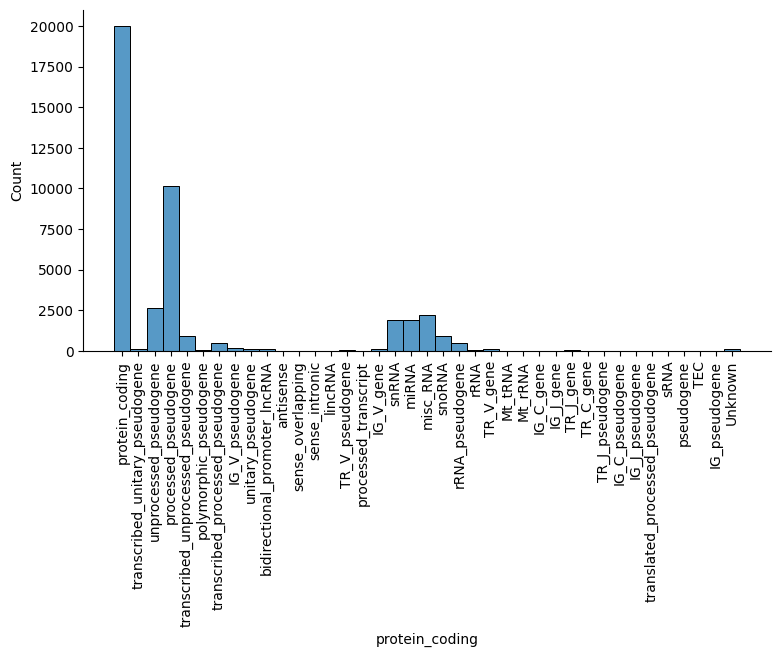

In [40]:
unique_labels = list(ids['protein_coding'].unique())
sns.displot(ids['protein_coding'])
fig           = plt.gcf()
fig.set_size_inches(10, 4)  # Adjust the width and height as needed
xticks = plt.xticks(rotation = 90)

# Scanpy Workflow

In [9]:
class ScanpyObject:

  # Data: Gene x Cell Row Matrix with Cells in index
  #       Columns Gene IDS correspond to the Columns

  # Leiden Groups: # of Groups for Clustering In Leiden Algorithm
  # Random State: The random seed introduced to Python for reproducability
  # PCA, UMAP, and TSNE utilitze a stochastic gradient algorithm (starting point matters)
  # PCA is determinsitic but due to the high rank of these datasets, "random PCA" may be used

  # Metalables: Title of Column Describing Gene Categorization
  #             For example: mRNA, Protein coding, siRNA, etc.,

  def __init__(self, data, leiden_groups = 15, random_state = 42, metalabels = 'protein_coding'):

    self.data_object        = sc.AnnData(data)
    self.data_highvar       = None
    self.leiden_gene_groups = leiden_groups   # TSNE Plots leiden groups
    self.random_state       = random_state    # Seed For Reproducability

    sc.pp.normalize_total(self.data_object)
    sc.pp.log1p(self.data_object)
    sc.pp.highly_variable_genes(self.data_object, min_mean=0.0125, max_mean=3, min_disp=0.5)
    self._preprocess_workflow(metalabels)
    self._regress_highvar()
    self._nearest_neighbors()
    self._dimension_reduction()

  def _dimension_reduction(self):
    sc.pp.pca(self.data_highvar, svd_solver = 'arpack', random_state = self.random_state)
    sc.tl.pca(self.data_highvar, svd_solver = 'arpack')
    sc.tl.rank_genes_groups(self.data_highvar, 'leiden', method='t-test')

  def _preprocess_workflow(self, metalabels):
    self._filter_cells()
    self._attach_metalabels(metalabels)
    self._calculate_qc_metrics()

  # Creates Another Object, With High Variability Genes Only
  def _regress_highvar(self):

    self.data_highvar  = self.data_object[:, self.data_object.var.highly_variable]
    sc.pp.regress_out(self.data_highvar, ['total_counts', 'pct_counts_Mt_rRNA'])

  # Leiden Clustering
  def _nearest_neighbors(self):
    sc.pp.neighbors(self.data_highvar, n_neighbors=10, n_pcs=40)
    sc.tl.leiden(self.data_highvar) # calculate the neighbors

  def _retreive_ranked_groups(self):
    gene_groups     = self.leiden_gene_groups
    gene_ranks_list = list(self.data_highvar.uns['rank_genes_groups']['names'])
    if len(gene_ranks_list) != 0:
      ranked_groups = gene_ranks_list[:gene_groups]

    return ranked_groups

  def _filter_cells(self):
    sc.pp.filter_cells(self.data_object, min_counts = 200)

  def _attach_metalabels(self, metalabels):
    for metalabel in ids[metalabels].unique():
      self.data_object.var[metalabel] = self.data_object.var_names.str.startswith(metalabel)

  def _calculate_qc_metrics(self):

    self.non_qc = ['highly_variable', 'means', 'dispersions', 'dispersions_norm']
    self.qc     = [col for col in self.data_object.var if col not in self.non_qc]

    sc.pp.calculate_qc_metrics(self.data_object, qc_vars=self.data_object.var[self.qc],
                                           percent_top=None, log1p=False, inplace=True)

  def leiden_ranking(self):
    sc.pl.rank_genes_groups(self.data_highvar, n_genes=self.leiden_gene_groups, sharey=False)

  def marker_genes(self):
    markers       = 2
    ranked_groups = self._retreive_ranked_groups()
    top_ranked    = {value: list(ranked_groups[value])[0:markers] for value in range(len(ranked_groups))}

    return top_ranked

  # -------------------------------------------------------------------------------------
  # Plot UMAP Takes The Highest Rank Marker Gene and Plots with UMAP
  # UMAP (Unifold Manifold) is a technique that aims to separate similar groups
  # UMAP is purely a visual technqiue, meaning the axes have no meaning
  # Separation does indicate that the groups are similar, but not as interpretable as PCA

  def plot_umap(self, color_type = 'highly_variable'):
    highly_variable = self.marker_genes()
    highly_variable = list(highly_variable.values())
    highly_variable = [gene[0] for gene in highly_variable]

    # # highly_variable = ['ENSG00000001561', 'ENSG00000286231']
    sc.tl.paga(self.data_highvar)
    sc.pl.paga(self.data_highvar, plot     =  False)  # remove `plot=False` if you want to see the coarse-grained graph
    sc.tl.umap(self.data_highvar, init_pos = 'paga')
    if color_type == 'highly_variable':
      sc.pl.umap(self.data_highvar, color=highly_variable)
    else:
      sc.pl.umap(self.data_highvar, color = color_type)

  def pca(self, gene_id = 'ENSG00000283761'):
    sc.pl.pca(self.data_highvar, color = gene_id, annotate_var_explained = True)

  def plot_high_expr(self):
    sc.pl.highest_expr_genes(self.data_object, n_top = 20)

  def plot_tsne(self):
    sc.tl.tsne(self.data_highvar, use_rep = 'X_pca')
    sc.pl.tsne(self.data_highvar, color=["leiden"], cmap="tab20")

  def scatter_plots(self):
    if not self.data_object.var.empty:
      total_plots = len(self.data_object.var.columns)
      fig, ax     = plt.subplots(8,5, figsize=(40,24))
      row         = 0
      col         = 0
      for plot in range(total_plots):
          protein_type = str(self.data_object.var.columns[plot])
          try:
            sc.pl.scatter(self.data_object, x='total_counts',
                          y = 'pct_counts_' + protein_type, ax = ax[row, col], show = False)
          # Deal with ax[row, col] calling for

          # Total Counts, n_genes_counts, etc
          except ValueError:
            col -= 1     # Counter Col += 1 Count


          col += 1
          if col > 4:
              row += 1
              col = 0
    else:
      raise ValueError(f'''{self.data_object.var} does not contain any data. Preprocess
      metalabels to receive scatter plots''')

  def plot_highly_variable(self):
    sc.pl.highly_variable_genes(self.data_object)

  def plot_pca_variance_ratio(self):
    sc.pl.pca_variance_ratio(self.data_highvar, log=True)

scanpy_obj1 = ScanpyObject(data)     # meta indexes data
scanpy_obj2 = ScanpyObject(data_obj) # original indexes data

         Falling back to preprocessing with `sc.pp.pca` and default params.


/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:420: 

         Falling back to preprocessing with `sc.pp.pca` and default params.


/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:420: 

In [ ]:
scanpy_obj2.data_object

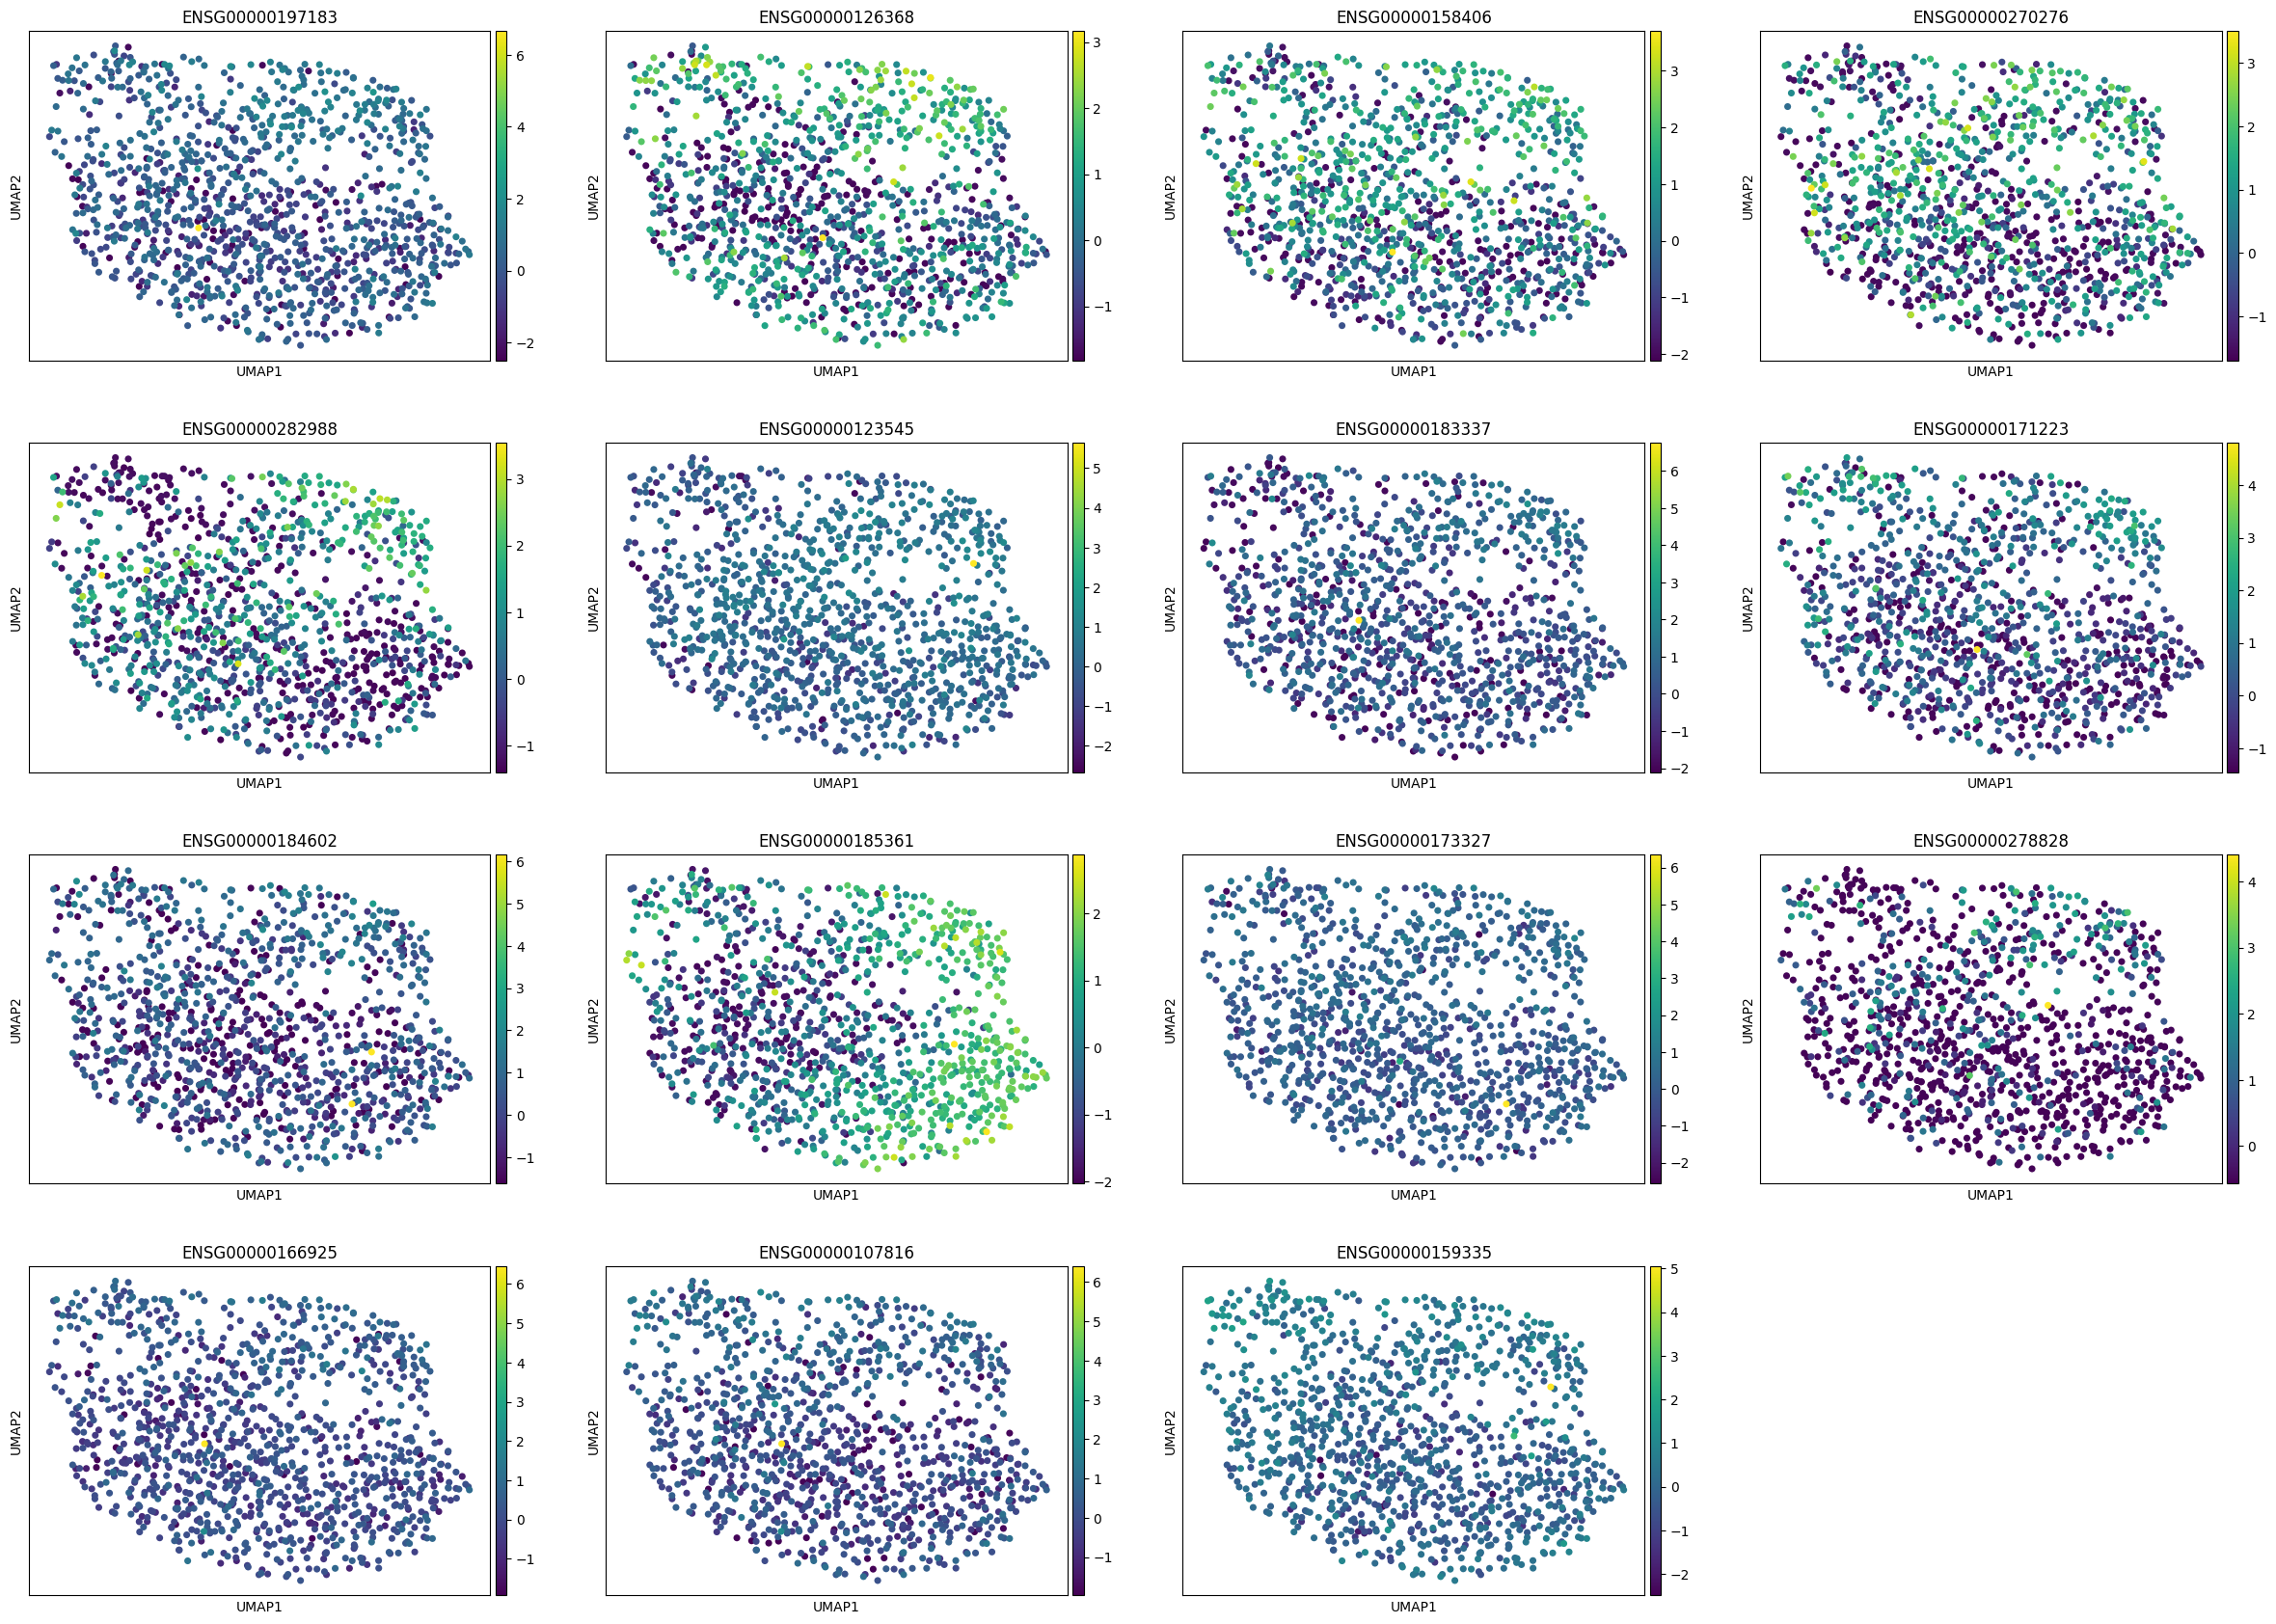

In [11]:
scanpy_obj2.plot_umap()

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


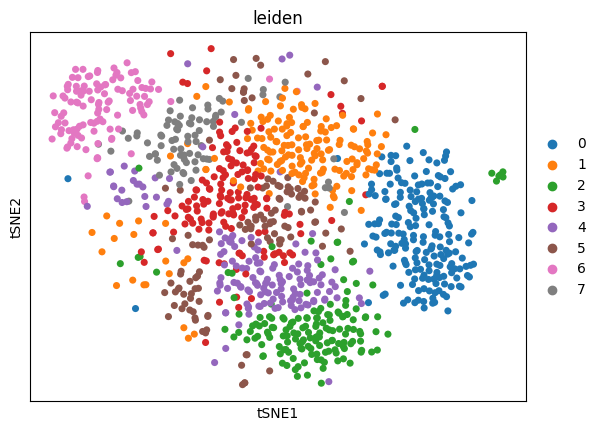

In [12]:
scanpy_obj2.plot_tsne()

In [ ]:
scanpy_obj2.leiden_ranking()

In [ ]:
ids.loc['ENSG00000184602']

In [ ]:
scanpy_obj2.marker_genes()

**Notes on Markers**
1. GROUP 0: ENSG00000197183 associated with Acute Leukemia, and a few other diseases
2. GROUP 1: ENSG00000126368. his gene encodes a transcription factor that is a member of the nuclear receptor subfamily 1. The encoded protein is a ligand-sensitive transcription factor that negatively regulates the expression of core clock proteins. In particular this protein represses the circadian clock transcription factor aryl hydrocarbon receptor nuclear translocator-like protein 1 (ARNTL). This protein may also be involved in regulating genes that function in metabolic, inflammatory and cardiovascular processes.

3. Group 2: ENSG00000158406. Histones are basic nuclear proteins that are responsible for the nucleosome structure of the chromosomal fiber in eukaryotes. Two molecules of each of the four core histones (H2A, H2B, H3, and H4) form an octamer, around which approximately 146 bp of DNA is wrapped in repeating units, called nucleosomes. The linker histone, H1, interacts with linker DNA between nucleosomes and functions in the compaction of chromatin into higher order structures. This gene is intronless and encodes a replication-dependent histone that is a member of the histone H4 family. Transcripts from this gene lack polyA tails but instead contain a palindromic termination element.

4. Group 3: ENSG00000270276 H4C15 (H4 Clustered Histone 15) is a Protein Coding gene. Diseases associated with H4C15 include Hyperoxaluria, Primary, Type I and Meier-Gorlin Syndrome 1. Among its related pathways are RNA Polymerase I Promoter Opening and Packaging Of Telomere Ends. An important paralog of this gene is H4C4.
5. Group 4: ENSG00000282988 The nucleosome is a histone octamer containing two molecules each of H2A, H2B, H3 and H4 assembled in one H3-H4 heterotetramer and two H2A-H2B heterodimers.
The octamer wraps approximately 147 bp of DNA.
6. Group 5: ENSG00000123545(NADH:ubiquinone oxidoreductase complex assembly factor 4) Prognostic marker in breast cancer (unfavorable)

7. Group 6: ENSG00000183337. BCOR (BCL6 Corepressor) is a Protein Coding gene. Diseases associated with BCOR include Microphthalmia, Syndromic 2 and Microphthalmia, Syndromic 1. Among its related pathways are Signaling events mediated by HDAC Class I and FBXL10 enhancement of MAP/ERK signaling in diffuse large B-cell lymphoma. Gene Ontology (GO) annotations related to this gene include transcription factor binding and transcription cis-regulatory region binding. An important paralog of this gene is BCORL1.
8. Group 7: ENSG00000171223. JUNB (JunB Proto-Oncogene, AP-1 Transcription Factor Subunit) is a Protein Coding gene. Diseases associated with JUNB include Anaplastic Large Cell Lymphoma and Lymphoma. Among its related pathways are IL-1 Family Signaling Pathways and Gene expression (Transcription). Gene Ontology (GO) annotations related to this gene include DNA-binding transcription factor activity and transcription factor binding. An important paralog of this gene is JUN.

9. Group 8:ENSG00000184602. Enables metal ion binding activity. Predicted to be involved in response to toxic substance. Located in cytoplasm. Is integral component of membrane.


# Next Steps
1. Collect gene ontology information for the marker genes



KeyError: ignored

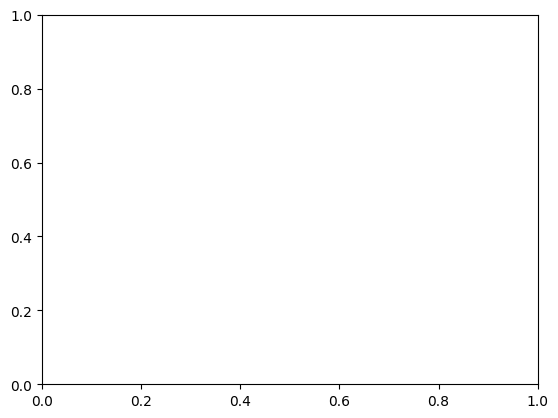

In [62]:
scanpy_obj2.plot_tsne()

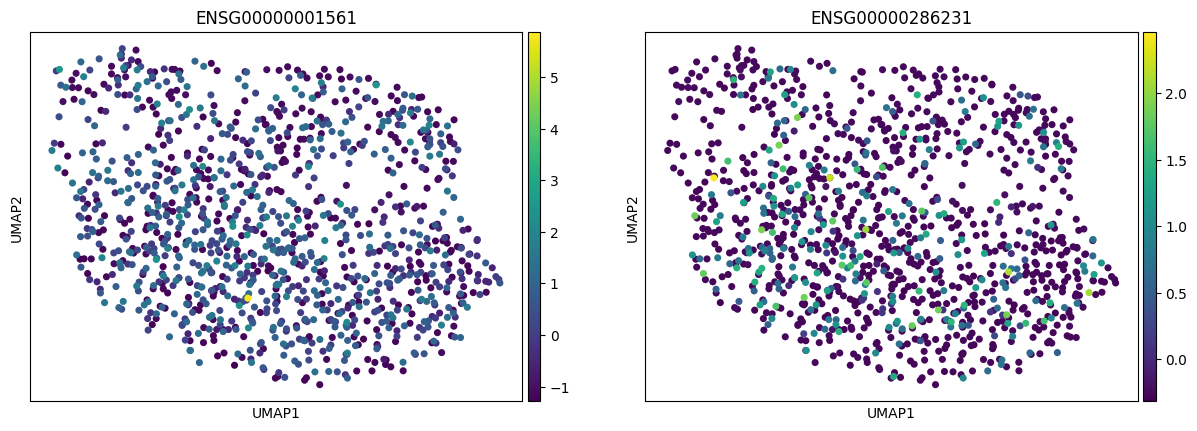

In [18]:
scanpy_obj2.plot_umap()

In [ ]:
# gene_groups = 15
# list(scanpy_obj2.data_highvar.uns['rank_genes_groups']['names'])[:gene_groups]

In [ ]:
# sc.pp.normalize_total(data_object)

In [ ]:
# for metalabel in ids['protein_coding'].unique():
#   data_object.var[metalabel] = data_object.var_names.str.startswith(metalabel)

In [ ]:
# sc.pp.calculate_qc_metrics(data_object, qc_vars=data_object.var,
#                            percent_top=None, log1p=False, inplace=True)

In [ ]:
# data_object.obs['n_genes_by_counts']

**Scatter Plots for Pct Counts vs. Total Counts**
1. Mitochondria Rna is Bottom Left Plot (~10-25% total coutns)
2. Protein Coding is top right
3. These are the most prevalant groups

In [ ]:
# total_plots = len(data_object.var.columns)
# fig, ax     = plt.subplots(8,5, figsize=(40,24))
# row         = 0
# col         = 0
# for plot in range(total_plots):
#     protein_type = str(data_object.var.columns[plot])
#     try:
#       sc.pl.scatter(data_object, x='total_counts',
#                     y = 'pct_counts_' + protein_type, ax = ax[row, col], show = False)
#     # Deal with ax[row, col] calling for

#     # Total Counts, n_genes_counts, etc
#     except ValueError:
#       col -= 1     # Counter Col += 1 Count


#     col += 1
#     if col > 4:
#         row += 1
#         col = 0

In [ ]:
# sc.pp.log1p(data_object)

In [ ]:
# sc.pp.highly_variable_genes(data_object, min_mean=0.0125, max_mean=3, min_disp=0.5)

In [ ]:
# sc.pl.highly_variable_genes(data_object)

In [ ]:
# data_highvar  = data_object[:, data_object.var.highly_variable]

In [ ]:
# sc.pp.regress_out(data_highvar, ['total_counts', 'pct_counts_Mt_rRNA'])
# sc.pp.scale(data_highvar, max_value=10)

In [ ]:
# sc.tl.pca(data_highvar, svd_solver='arpack')

In [ ]:
# sc.pl.pca(data_highvar, color = 'ENSG00000286190', annotate_var_explained = True)

**Standard Deviations of Variance Captured by PCS**

In [ ]:
# sc.pl.pca_variance_ratio(data_highvar, log=True)

**Plot Matrix of first 30 PC's**

In [ ]:
# max_pcs   = 6
# pc_dict   = {index: PC for index, PC in enumerate(data_highvar.varm['PCs']) if index < max_pcs}
# fig, ax   = plt.subplots(6, 6, figsize = (25, 18))

# col, row  = 0
# for index, pc in pc_dict.items():
#   ax[row, col] = sc.pl.pca(data_object)

SyntaxError: ignored

In [ ]:
# sc.pp.neighbors(data_highvar, n_neighbors=10, n_pcs=40)

In [ ]:
# sc.tl.leiden(data_highvar)

**No Real Separation**

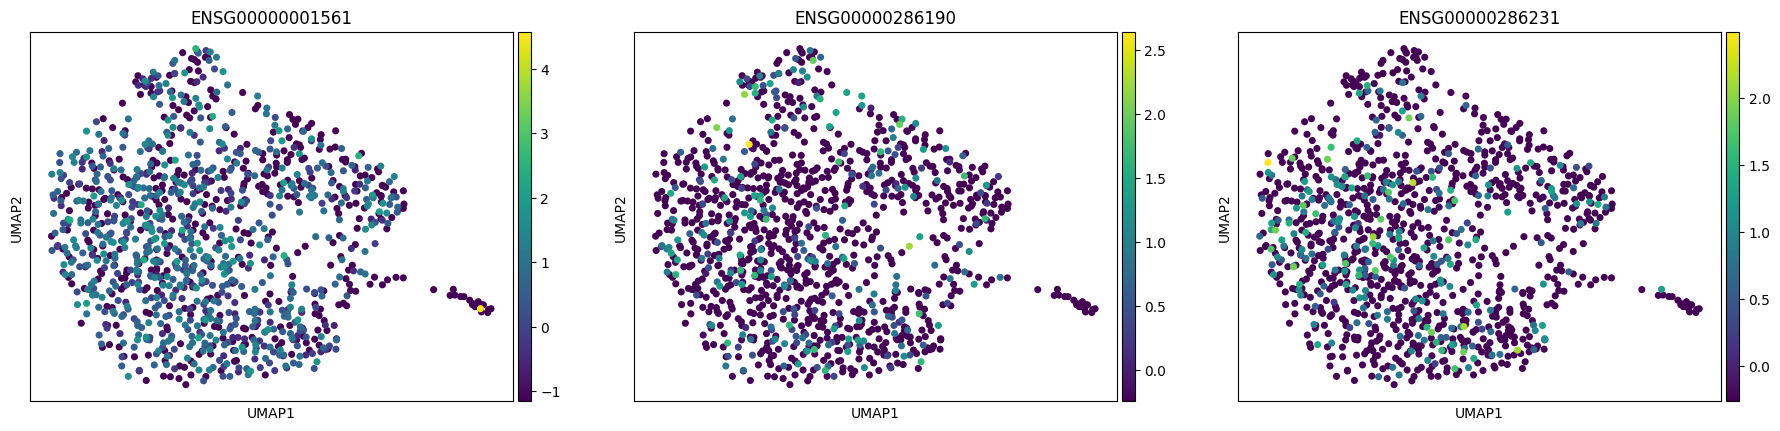

In [ ]:
# import igraph

# sc.tl.paga(data_highvar)
# sc.pl.paga(data_highvar, plot     =  False)  # remove `plot=False` if you want to see the coarse-grained graph
# sc.tl.umap(data_highvar, init_pos = 'paga')

# highly_variable = ['ENSG00000001561', 'ENSG00000286190',
#                    'ENSG00000286231']
# sc.pl.umap(data_highvar, color=highly_variable)

In [ ]:
# sc.tl.rank_genes_groups(data_highvar, 'leiden', method='t-test')
# sc.pl.rank_genes_groups(data_highvar, n_genes=15, sharey=False)

**Next Step**
1. Write Marker Genes into A Dictionary and categorize cells